# View Roadway

In [1]:
using AutomotiveDrivingModels
include(Pkg.dir("AutomotiveDrivingModels", "src", "viz", "AutoViz.jl"))
using AutoViz

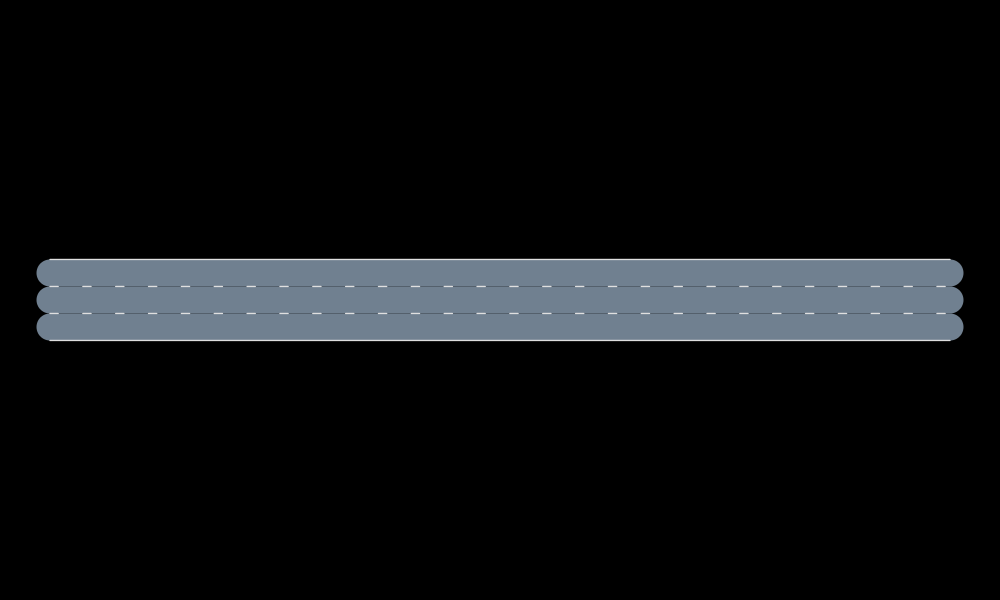

In [3]:
render(gen_straight_roadway(3, 100.0))

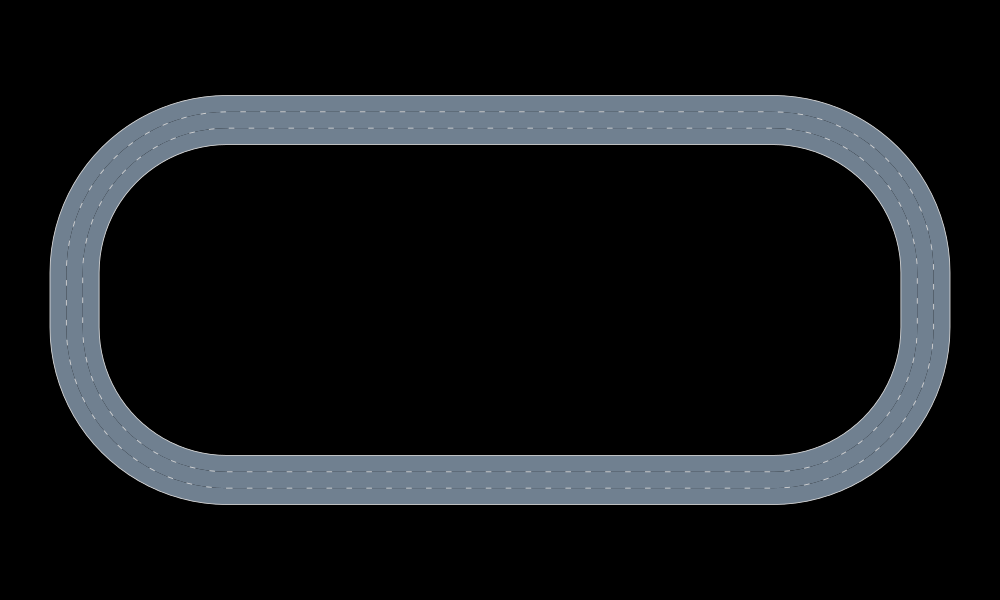

In [4]:
render(gen_stadium_roadway(3))

Loading RNDF... no current lane to assign speed limit to
elapsed time: 0.822219832 seconds
Building roadway... Convert RNDF to Roadway
BUILDING GRAPH [0.00]
ADDING EXIT EDGES [0.26]
ADDING NODES TO ROADWAY [0.26]
CONNECTING HANGING EDGES [0.28]
MISSING 33.27.830
MISSING 33.27.791
MISSING 33.27.895
MISSING 33.27.798
MISSING 33.27.909
MISSING 33.27.882
MISSING 33.27.894
MISSING 33.27.867
MISSING 33.27.848
MISSING 33.27.796
MISSING 33.27.900
MISSING 33.27.888
MISSING 33.27.905
MISSING 33.27.811
MISSING 33.27.825
MISSING 33.27.844
MISSING 33.27.876
MISSING 33.27.892
MISSING 33.27.868
MISSING 33.27.893
MISSING 33.27.907
MISSING 33.27.799
MISSING 33.27.818
MISSING 33.27.865
MISSING 33.27.849
MISSING 33.27.871
MISSING 33.27.828
MISSING 33.27.886
MISSING 33.27.874
MISSING 33.27.852
MISSING 33.27.815
MISSING 33.27.835
MISSING 33.27.873
MISSING 33.27.820
MISSING 33.27.817
MISSING 33.27.802
MISSING 33.27.853
MISSING 33.27.803
MISSING 33.27.833
MISSING 33.27.814
MISSING 33.27.801
MISSING 33.27.816

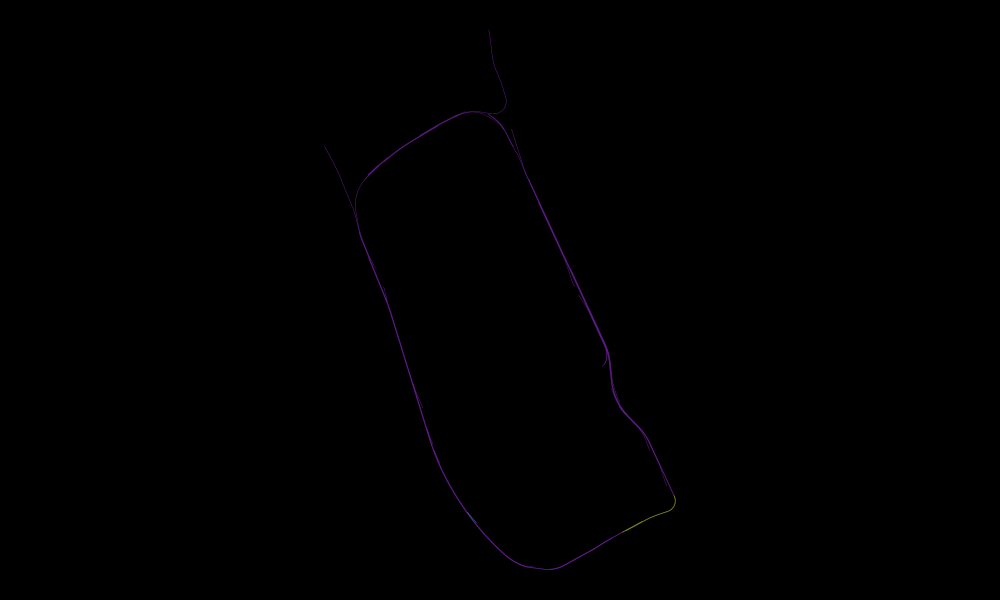

In [5]:
using RoadNetworks
include("/home/tim/.julia/v0.4/BoschData/scripts/gen_roadways.jl")

RNDF_FILE = "/media/tim/DATAPART1/Data/Bosch/source2/detroit_v4_rndf_copy.txt"
ROADWAY_OUTPUT_FILE = "/media/tim/DATAPART1/Data/Bosch/processed/streetmaps/streetmap_detroit_v4.jld"


@printf("Loading RNDF... "); tic()
rndf = load_rndf(RNDF_FILE)
toc()

@printf("Building roadway... "); tic()
roadway = convert(Roadway, rndf, verbosity=2)
toc()

rendermodel = RenderModel()
s = CairoRGBSurface(DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
ctx = creategc(s)
clear_setup!(rendermodel)

render!(rendermodel, roadway)

camera_fit_to_content!(rendermodel, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
render(rendermodel, ctx, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
s

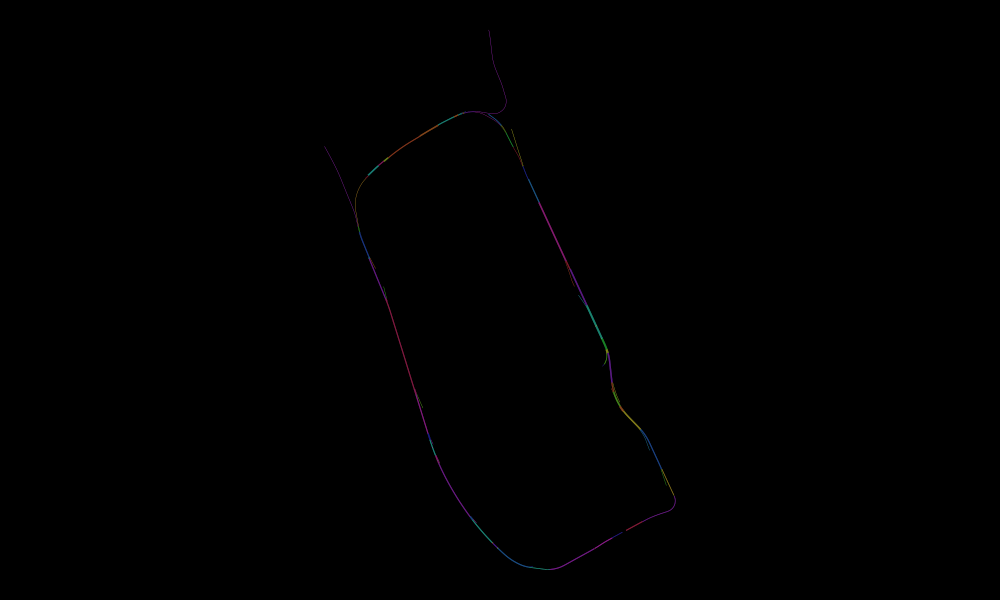

In [55]:
include("/home/tim/.julia/v0.4/BoschData/scripts/gen_roadways.jl")
roadway2 = resegment_roadway(roadway)

rendermodel = RenderModel()
s = CairoRGBSurface(DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
ctx = creategc(s)
clear_setup!(rendermodel)

render!(rendermodel, roadway2)

camera_fit_to_content!(rendermodel, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
render(rendermodel, ctx, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
s

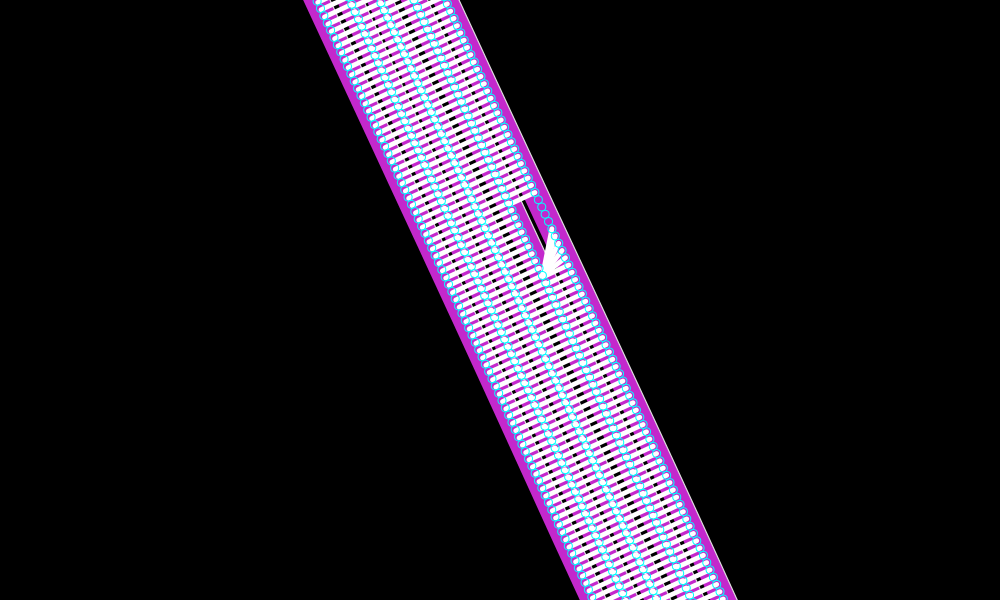

In [129]:
srand(0)
rendermodel = RenderModel()
s = CairoRGBSurface(DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
ctx = creategc(s)
clear_setup!(rendermodel)

render!(rendermodel, roadway)

target_lane = roadway[LaneTag(27,1)]
midpt_s = target_lane.curve[end].s / 2
midpt_ind = get_curve_index(target_lane.curve, midpt_s)
midpt = target_lane.curve[midpt_ind]

# render!(rendermodel, target_lane, roadway, color_asphalt=colorant"yellow")
# render!(rendermodel, roadway[LaneTag(27,1)], roadway, color_asphalt=colorant"red")

Δs = 1.0
const ANGLE_ACCEPT = deg2rad(30.0)

conL = Dict{LaneTag, Vector{RoadIndex}}() # conL[tag][i] gives CurveInd -> RoadInd for roadway[tag] at s = Δs*(i-1)
conR = Dict{LaneTag, Vector{RoadIndex}}() # conR[tag][i] gives CurveInd -> RoadInd for roadway[tag] at s = Δs*(i-1)
assigned = Dict{LaneTag, BitVector}() # whether a pt has already been assigned

# part 1 - calc neighborness
for seg in roadway.segments
    for lane in seg.lanes

        tot_s = lane.curve[end].s
        s_vals = 0.0:Δs:tot_s
        N = length(s_vals)
        roadindsL = fill(NULL_ROADINDEX, N)
        roadindsR = fill(NULL_ROADINDEX, N)

        ind = CurveIndex(1,0.0)
        for i in 1 : N
            if i > 1
                ind = get_curve_index(ind, lane.curve, Δs)
            end
            pt = lane.curve[ind]

            min_dist_L = 6.0
            min_dist_R = 6.0

            for seg2 in roadway.segments
                for lane2 in seg2.lanes
                    if lane2.tag != lane.tag
                        curveproj = proj(pt.pos, lane2.curve)
                        if !is_at_curve_end(curveproj.ind, lane2.curve)
                            dist = abs(pt.pos - lane2.curve[curveproj.ind].pos)

                            # check if lane2 is on left
                            if curveproj.t < 0.0 && abs(curveproj.ϕ) < ANGLE_ACCEPT && dist < min_dist_L
                                min_dist_L = dist
                                roadindsL[i] = RoadIndex(curveproj.ind, lane2.tag)
                                
#                                 pt2 = lane2.curve[curveproj.ind]
#                                 pts = [pt.pos.x pt2.pos.x; pt.pos.y pt2.pos.y]
#                                 add_instruction!(rendermodel, render_line, (pts, colorant"white", 0.6))
                                
                            # check if lane2 is on right
                            elseif curveproj.t > 0.0 && abs(curveproj.ϕ) < ANGLE_ACCEPT && dist < min_dist_R
                                min_dist_R = dist
                                roadindsR[i] = RoadIndex(curveproj.ind, lane2.tag)
                                
                                pt2 = lane2.curve[curveproj.ind]
                                pts = [pt.pos.x pt2.pos.x; pt.pos.y pt2.pos.y]
                                add_instruction!(rendermodel, render_line, (pts, colorant"white", 0.6))
                            end
                        end
                    end
                end
            end
        end

        conL[lane.tag] = roadindsL
        conR[lane.tag] = roadindsR
        assigned[lane.tag] = falses(N)
    end
end

# part 2 - approximate segments
retval = Roadway()
for seg in roadway.segments
    for lane in seg.lanes
        a = assigned[lane.tag]
        i = findfirst(a, false)
        while i != 0

            # identify neighbors
            cross_sections_in_seg = Tuple{Vector{LaneTag},Vector{Int}}[]

            i_lo = i
            push!(cross_sections_in_seg, _get_cross_section(lane, i_lo, conL, conR, Δs))

            # scan forward until we get a different cross section
            done = false
            while !done
                i += 1
                if i > length(a) || a[i] == true
                    done = true
                else
                    cs2 = _get_cross_section(lane, i, conL, conR, Δs)
                    # check for equivalence
                    if _cross_sections_are_equal(cross_sections_in_seg[1], cs2)
                        push!(cross_sections_in_seg, cs2)
                    else
                        done = true
                    end
                end
            end
            i_hi = i - 1 # back it up to last valid point
            
            # debug
#             for cs in cross_sections_in_seg
#                 tags, is = cs
#                 pts = Array(Float64, 2, length(tags))
#                 for k in 1 : length(tags)
#                     lane2 = roadway[tags[k]]
#                     ind2 = get_curve_index(lane2.curve, Δs*(is[k]-1))
#                     pt2 = lane2.curve[ind2]
#                     pts[1,k] = pt2.pos.x
#                     pts[2,k] = pt2.pos.y
#                 end
#                 add_instruction!(rendermodel, render_line, (pts, colorant"white", 0.6))
#             end
            
            # build the segment from i_lo : i_hi
            segid = length(retval.segments)+1 # assign next available segment id
            lanes = Array(Lane, length(cross_sections_in_seg[1][1]))
            for j in 1 : length(lanes) # build the lanes
                tag = LaneTag(segid, j)
                targetlane = roadway[cross_sections_in_seg[1][1][j]]

                curve_i_lo = get_curve_index(targetlane.curve, Δs*(cross_sections_in_seg[1][2][j]-1)).i 
                curve_i_hi = get_curve_index(targetlane.curve, Δs*(cross_sections_in_seg[end][2][j]-1)).i 
                curve = targetlane.curve[curve_i_lo : curve_i_hi]

                lanes[j] = Lane(tag, curve,
                        width = targetlane.width,
                        boundary_left = targetlane.boundary_left,
                        boundary_right = targetlane.boundary_right,
                        # TODO: handle prev and next
                    )

                # mark everything as taken
                for k in 1 : length(cross_sections_in_seg)
                    assigned[cross_sections_in_seg[k][1][j]][cross_sections_in_seg[k][2][j]] = true
                end
            end

            push!(retval.segments, RoadSegment(segid, lanes))
            #####

            i = findnext(a, false, i)
        end
    end
end

for seg in roadway.segments
    for lane in seg.lanes
        
        tot_s = lane.curve[end].s
        s_vals = 0.0:Δs:tot_s
        N = length(s_vals)
        
        pts = Array(Float64, 2, N)
        for i in 1:N
            ind = get_curve_index(lane.curve, Δs*(i-1))
            pt = lane.curve[ind]
            pts[1,i] = pt.pos.x
            pts[2,i] = pt.pos.y
            
#             p2 = pt.pos + polar(1.0, pt.pos.θ+π/2)
#             color = convert(RGB, HSL(mod(pt.s*2, 360), 1.0, 0.5))
#             add_instruction!(rendermodel, render_line, ([pt.pos.x p2.x;pt.pos.y p2.y], color, 0.5))

#             for seg2 in roadway.segments
#                 for lane2 in seg2.lanes
#                     if lane2.tag != lane.tag
#                         curveproj = proj(pt.pos, lane2.curve)
#                         if !is_at_curve_end(curveproj.ind, lane2.curve)
#                             dist = abs(pt.pos - lane2.curve[curveproj.ind].pos)
#                             if abs(dist) < 6.0
#                                 p2 = lane2.curve[curveproj.ind].pos
#                                 add_instruction!(rendermodel, render_line, ([pt.pos.x p2.x;pt.pos.y p2.y], colorant"yellow", 0.5))
#                             end
#                         end
#                     end
#                 end
#             end
        end
        add_instruction!(rendermodel, render_point_trail, (pts, colorant"cyan", 0.5))
        
#         N = length(lane.curve)
#         pts = Array(Float64, 2, N)
#         for i in 1:N
#             pt = lane.curve[i]
#             pts[1,i] = pt.pos.x
#             pts[2,i] = pt.pos.y
#         end
#         add_instruction!(rendermodel, render_point_trail, (pts, colorant"white", 0.5))
    end
end

camera_set_pos!(rendermodel, midpt.pos + VecE2(-50.0,180.0))
camera_zoom!(rendermodel, 8.0)
render(rendermodel, ctx, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
s

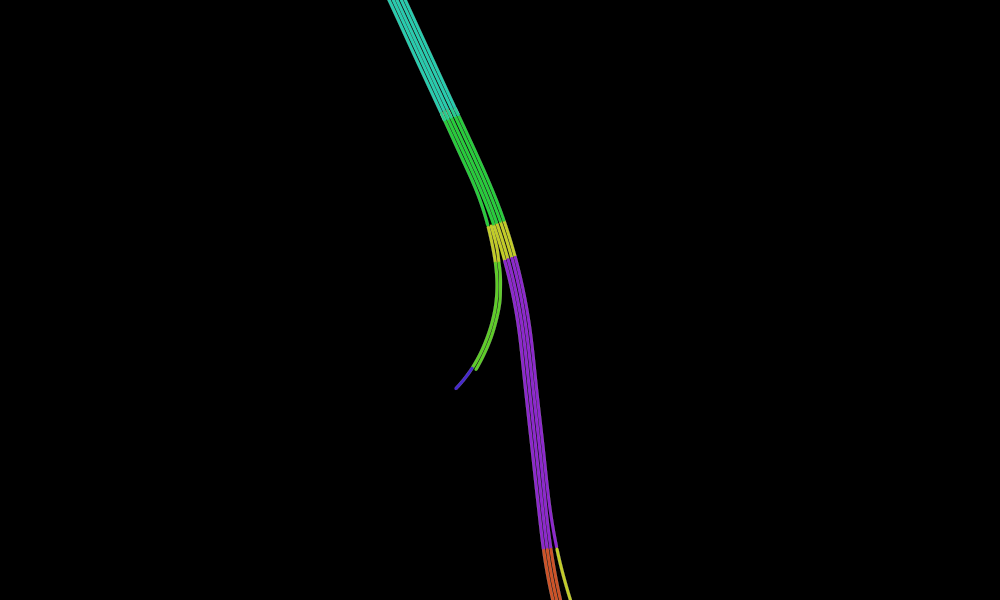

In [130]:
rendermodel = RenderModel()
s = CairoRGBSurface(DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
ctx = creategc(s)
clear_setup!(rendermodel)

render!(rendermodel, roadway2)

target_lane = roadway[LaneTag(27,1)]
midpt_s = target_lane.curve[end].s / 2
midpt_ind = get_curve_index(target_lane.curve, midpt_s)
midpt = target_lane.curve[midpt_ind]
camera_set_pos!(rendermodel, midpt.pos)
camera_zoom!(rendermodel, 1)

# render!(rendermodel, target_lane, roadway, color_asphalt=colorant"yellow")
# render!(rendermodel, roadway[LaneTag(27,1)], roadway, color_asphalt=colorant"red")


# camera_fit_to_content!(rendermodel, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
render(rendermodel, ctx, DEFAULT_CANVAS_WIDTH, DEFAULT_CANVAS_HEIGHT)
s

In [8]:
include("/home/tim/.julia/v0.4/BoschData/scripts/gen_roadways.jl")
for seg in roadway.segments
    println("")
    for i in 2 : length(seg.lanes)
        println(seg.lanes[i].tag)
#         println(is_lane_left_of(seg.lanes[i], seg.lanes[i-1]))
    end
end


AutomotiveDrivingModels.AutoCore.LaneTag(27,2)
AutomotiveDrivingModels.AutoCore.LaneTag(27,3)
AutomotiveDrivingModels.AutoCore.LaneTag(27,4)
AutomotiveDrivingModels.AutoCore.LaneTag(27,5)
AutomotiveDrivingModels.AutoCore.LaneTag(27,6)
AutomotiveDrivingModels.AutoCore.LaneTag(27,7)
AutomotiveDrivingModels.AutoCore.LaneTag(27,8)
AutomotiveDrivingModels.AutoCore.LaneTag(27,9)
AutomotiveDrivingModels.AutoCore.LaneTag(27,10)
AutomotiveDrivingModels.AutoCore.LaneTag(27,11)
AutomotiveDrivingModels.AutoCore.LaneTag(27,12)
AutomotiveDrivingModels.AutoCore.LaneTag(27,13)
AutomotiveDrivingModels.AutoCore.LaneTag(27,14)
AutomotiveDrivingModels.AutoCore.LaneTag(27,15)
AutomotiveDrivingModels.AutoCore.LaneTag(27,16)
AutomotiveDrivingModels.AutoCore.LaneTag(27,17)
AutomotiveDrivingModels.AutoCore.LaneTag(27,18)
AutomotiveDrivingModels.AutoCore.LaneTag(27,19)
AutomotiveDrivingModels.AutoCore.LaneTag(27,20)
AutomotiveDrivingModels.AutoCore.LaneTag(27,21)
AutomotiveDrivingModels.AutoCore.LaneTag(27,22)